Hex file           : ../data/processed/hex_grids/mexico_sci_hex_res8.geojson
Hexes loaded        : 26,132
AGEBs loaded        : 48,070
No hex_coverage column found; validating all hexes in file.


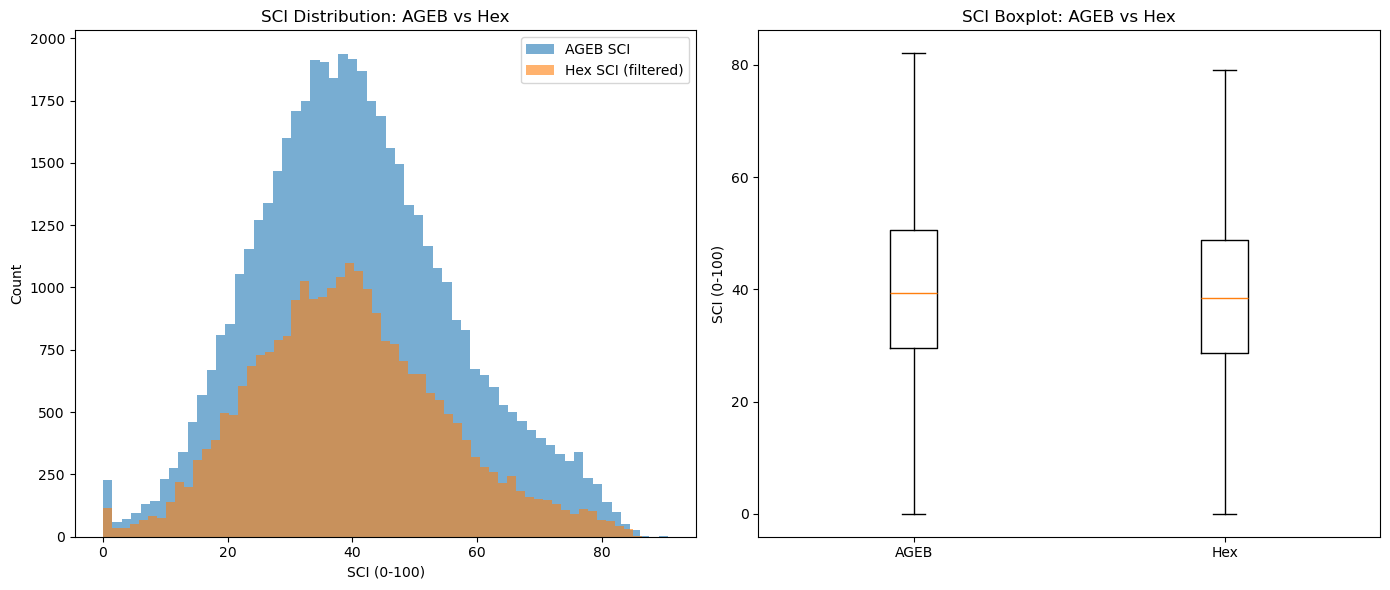


SCI STATISTICS SUMMARY
AGEB Mean SCI            : 40.51
Hex Mean SCI (filtered)  : 39.28
Hex High (>70)           : 3.7%
Hex Low (<40)            : 54.4%

SPATIALLY MATCHED VALIDATION
Matched hexes: 26,132
Area-weighted AGEB equiv → n=26,132 r=0.988 MAE=1.183 RMSE=2.431 Bias=0.001
Pop-weighted  AGEB equiv → n=26,132 r=1.000 MAE=0.084 RMSE=0.318 Bias=0.014


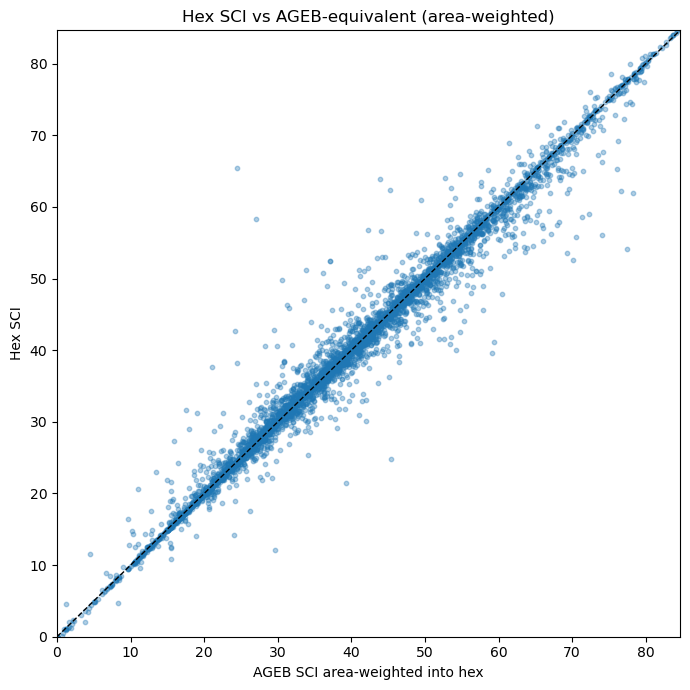

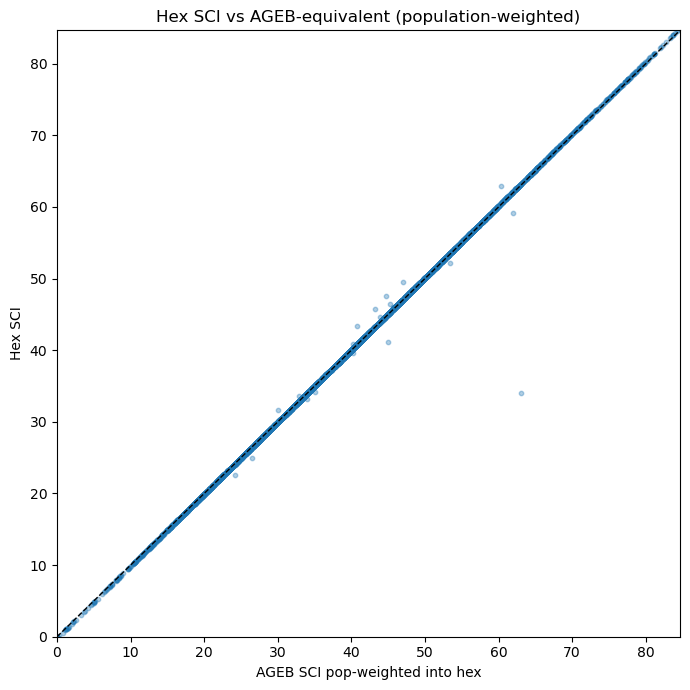


GDL  → Mean SCI: 49.39 | High (>70): 14.2%
CDMX → Mean SCI: 50.56 | High (>70): 9.0%

Saved: ../data/processed/validation/hex_vs_ageb_equivalent.csv


In [24]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from pathlib import Path

# ---------------------------
# Paths
# ---------------------------
# Prefer the covered layer if you have it.
hex_path_candidates = [
    '../data/processed/hex_grids/mexico_sci_hex_res8_covered.geojson',
    '../data/processed/hex_grids/mexico_sci_hex_res8.geojson',
]
ageb_path = '../data/processed/indices/sci_national.parquet'

# Output (optional)
out_dir = Path('../data/processed/validation')
out_dir.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Settings
# ---------------------------
EQUAL_AREA_EPSG = 6933
MIN_HEX_COVERAGE = 0.12   # filter for validation if hex_coverage exists
MAX_SCATTER = 5000        # scatter sample size
RANDOM_SEED = 42

# ---------------------------
# Load data
# ---------------------------
hex_path = None
for p in hex_path_candidates:
    if Path(p).exists():
        hex_path = p
        break
if hex_path is None:
    raise FileNotFoundError(f'No hex file found. Tried: {hex_path_candidates}')

sci_hex = gpd.read_file(hex_path)
ageb_sci = gpd.read_parquet(ageb_path)

# Basic cleaning
sci_hex = sci_hex[sci_hex.geometry.notna()].copy()
ageb_sci = ageb_sci[ageb_sci.geometry.notna()].copy()

sci_hex['SCI'] = pd.to_numeric(sci_hex.get('SCI'), errors='coerce')
ageb_sci['SCI'] = pd.to_numeric(ageb_sci.get('SCI'), errors='coerce')

sci_hex = sci_hex[sci_hex['SCI'].notna()].copy()
ageb_sci = ageb_sci[ageb_sci['SCI'].notna()].copy()

# CRS alignment
if sci_hex.crs is None:
    raise ValueError('Hex layer has no CRS set. Set it before validating.')
if ageb_sci.crs is None:
    raise ValueError('AGEB layer has no CRS set. Set it before validating.')
if sci_hex.crs != ageb_sci.crs:
    ageb_sci = ageb_sci.to_crs(sci_hex.crs)

print(f'Hex file           : {hex_path}')
print(f'Hexes loaded        : {len(sci_hex):,}')
print(f'AGEBs loaded        : {len(ageb_sci):,}')

# Coverage filter (if present)
if 'hex_coverage' in sci_hex.columns:
    sci_hex['hex_coverage'] = pd.to_numeric(sci_hex['hex_coverage'], errors='coerce')
    before = len(sci_hex)
    sci_hex_cov = sci_hex[sci_hex['hex_coverage'].fillna(0) >= MIN_HEX_COVERAGE].copy()
    print(f'Hexes after coverage>= {MIN_HEX_COVERAGE:.2f}: {len(sci_hex_cov):,} (dropped {before-len(sci_hex_cov):,})')
else:
    sci_hex_cov = sci_hex.copy()
    print('No hex_coverage column found; validating all hexes in file.')

# =========================================================
# 1) Distribution comparison (matplotlib only)
# =========================================================
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(ageb_sci['SCI'].dropna(), bins=60, alpha=0.6, label='AGEB SCI')
plt.hist(sci_hex_cov['SCI'].dropna(), bins=60, alpha=0.6, label='Hex SCI (filtered)')
plt.title('SCI Distribution: AGEB vs Hex')
plt.xlabel('SCI (0-100)')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(
    [ageb_sci['SCI'].dropna().values, sci_hex_cov['SCI'].dropna().values],
    labels=['AGEB', 'Hex'],
    showfliers=False
)
plt.title('SCI Boxplot: AGEB vs Hex')
plt.ylabel('SCI (0-100)')

plt.tight_layout()
plt.show()

print('\n' + '='*60)
print('SCI STATISTICS SUMMARY')
print('='*60)
print(f'AGEB Mean SCI            : {ageb_sci["SCI"].mean():.2f}')
print(f'Hex Mean SCI (filtered)  : {sci_hex_cov["SCI"].mean():.2f}')
print(f'Hex High (>70)           : {(sci_hex_cov["SCI"] > 70).mean():.1%}')
print(f'Hex Low (<40)            : {(sci_hex_cov["SCI"] < 40).mean():.1%}')

# =========================================================
# 2) Spatially matched validation
#    Compute AGEB-equivalent SCI per hex using BOTH:
#      A) area-weighting (always valid)
#      B) population-weighting (if POBTOT exists)
# =========================================================
# Use equal-area CRS for area computations
hex_eq = sci_hex_cov[['SCI', 'geometry']].copy().to_crs(EQUAL_AREA_EPSG)
ageb_eq_cols = ['SCI', 'geometry']
has_pop = 'POBTOT' in ageb_sci.columns
if has_pop:
    ageb_sci['POBTOT'] = pd.to_numeric(ageb_sci['POBTOT'], errors='coerce')
    ageb_eq_cols = ['SCI', 'POBTOT', 'geometry']

ageb_eq = ageb_sci[ageb_eq_cols].copy().to_crs(EQUAL_AREA_EPSG)

# Create stable ids (do NOT rely on index alignment)
hex_eq = hex_eq.reset_index(drop=True)
ageb_eq = ageb_eq.reset_index(drop=True)
hex_eq['hex_id'] = np.arange(len(hex_eq), dtype=np.int64)
ageb_eq['ageb_id'] = np.arange(len(ageb_eq), dtype=np.int64)

# Intersection
inter = gpd.overlay(
    hex_eq[['hex_id', 'SCI', 'geometry']],
    ageb_eq[['ageb_id', 'SCI', 'geometry'] + (['POBTOT'] if has_pop else [])],
    how='intersection'
).rename(columns={'SCI_1': 'SCI_hex', 'SCI_2': 'SCI_ageb'})

if inter.empty:
    raise RuntimeError('Overlay produced no intersections. Check CRS alignment and geometries.')

inter['overlap_area'] = inter.geometry.area
inter = inter[inter['overlap_area'] > 0].copy()

# -------- Area-weighted AGEB-equivalent per hex (stable) --------
area_sum = inter.groupby('hex_id')['overlap_area'].sum()
inter = inter.join(area_sum.rename('area_total'), on='hex_id')
inter['w_area'] = inter['overlap_area'] / inter['area_total']

hex_area_equiv = (
    inter.assign(ageb_area_w = inter['SCI_ageb'] * inter['overlap_area'])
        .groupby('hex_id', as_index=False)
        .agg(area_total=('overlap_area','sum'), ageb_area_w=('ageb_area_w','sum'))
)
hex_area_equiv['SCI_ageb_area_weighted'] = hex_area_equiv['ageb_area_w'] / hex_area_equiv['area_total']

# -------- Population-weighted AGEB-equivalent per hex (optional) --------
hex_pop_equiv = None
if has_pop:
    # Estimate pop in intersection by AGEB pop density * overlap area
    # pop_density = POBTOT / AGEB_area (in equal-area CRS)
    ageb_area = ageb_eq[['ageb_id','geometry']].copy()
    ageb_area['ageb_area'] = ageb_area.geometry.area
    inter = inter.merge(ageb_area[['ageb_id','ageb_area']], on='ageb_id', how='left')

    inter['pop_density'] = np.where(
        (inter['ageb_area'] > 0) & inter['POBTOT'].notna(),
        inter['POBTOT'] / inter['ageb_area'],
        np.nan
    )
    inter['pop_est'] = inter['pop_density'] * inter['overlap_area']
    inter.loc[~np.isfinite(inter['pop_est']), 'pop_est'] = 0.0

    hex_pop_equiv = (
        inter.assign(ageb_pop_w = inter['SCI_ageb'] * inter['pop_est'])
            .groupby('hex_id', as_index=False)
            .agg(pop_total=('pop_est','sum'), ageb_pop_w=('ageb_pop_w','sum'))
    )
    hex_pop_equiv['SCI_ageb_pop_weighted'] = np.where(
        hex_pop_equiv['pop_total'] > 0,
        hex_pop_equiv['ageb_pop_w'] / hex_pop_equiv['pop_total'],
        np.nan
    )

# -------- Merge comparisons --------
hex_base = hex_eq[['hex_id','SCI']].rename(columns={'SCI':'SCI_hex'})
hex_compare = hex_base.merge(hex_area_equiv[['hex_id','SCI_ageb_area_weighted']], on='hex_id', how='inner')

if hex_pop_equiv is not None:
    hex_compare = hex_compare.merge(hex_pop_equiv[['hex_id','SCI_ageb_pop_weighted','pop_total']], on='hex_id', how='left')

print('\n' + '='*60)
print('SPATIALLY MATCHED VALIDATION')
print('='*60)
print(f'Matched hexes: {len(hex_compare):,}')

def _metrics(x, y):
    x = pd.to_numeric(x, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    m = pd.DataFrame({'x':x, 'y':y}).dropna()
    if len(m) < 3:
        return {'n': len(m), 'r': np.nan, 'mae': np.nan, 'rmse': np.nan, 'bias': np.nan}
    r = pearsonr(m['x'], m['y'])[0]
    mae = np.mean(np.abs(m['x'] - m['y']))
    rmse = np.sqrt(np.mean((m['x'] - m['y'])**2))
    bias = np.mean(m['x'] - m['y'])
    return {'n': len(m), 'r': float(r), 'mae': float(mae), 'rmse': float(rmse), 'bias': float(bias)}

m_area = _metrics(hex_compare['SCI_hex'], hex_compare['SCI_ageb_area_weighted'])
print(f'Area-weighted AGEB equiv → n={m_area["n"]:,} r={m_area["r"]:.3f} MAE={m_area["mae"]:.3f} RMSE={m_area["rmse"]:.3f} Bias={m_area["bias"]:.3f}')

if 'SCI_ageb_pop_weighted' in hex_compare.columns:
    m_pop = _metrics(hex_compare['SCI_hex'], hex_compare['SCI_ageb_pop_weighted'])
    print(f'Pop-weighted  AGEB equiv → n={m_pop["n"]:,} r={m_pop["r"]:.3f} MAE={m_pop["mae"]:.3f} RMSE={m_pop["rmse"]:.3f} Bias={m_pop["bias"]:.3f}')
else:
    print('Population-weighted equiv: skipped (POBTOT not present).')

# Scatter plots
def _scatter(x, y, title, xlabel, ylabel):
    df = pd.DataFrame({'x':x, 'y':y}).dropna()
    if df.empty:
        print(f'No data for: {title}')
        return
    df = df.sample(min(MAX_SCATTER, len(df)), random_state=RANDOM_SEED)
    plt.figure(figsize=(7,7))
    plt.scatter(df['x'], df['y'], s=10, alpha=0.35)
    lims = [min(df['x'].min(), df['y'].min()), max(df['x'].max(), df['y'].max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlim(lims); plt.ylim(lims)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

_scatter(hex_compare['SCI_ageb_area_weighted'], hex_compare['SCI_hex'],
         'Hex SCI vs AGEB-equivalent (area-weighted)',
         'AGEB SCI area-weighted into hex', 'Hex SCI')

if 'SCI_ageb_pop_weighted' in hex_compare.columns:
    _scatter(hex_compare['SCI_ageb_pop_weighted'], hex_compare['SCI_hex'],
             'Hex SCI vs AGEB-equivalent (population-weighted)',
             'AGEB SCI pop-weighted into hex', 'Hex SCI')

# =========================================================
# 3) Error vs coverage (if coverage exists)
# =========================================================
if 'hex_coverage' in sci_hex_cov.columns:
    # map hex_id back to original hex coverage via spatial join isn't needed;
    # we can just align by position because hex_eq was built from sci_hex_cov ordering.
    cov = sci_hex_cov['hex_coverage'].reset_index(drop=True)
    cov_df = pd.DataFrame({'hex_id': hex_eq['hex_id'], 'hex_coverage': cov})
    err_df = hex_compare.merge(cov_df, on='hex_id', how='left')

    err_df['abs_err_area'] = np.abs(err_df['SCI_hex'] - err_df['SCI_ageb_area_weighted'])
    plt.figure(figsize=(9,5))
    plt.scatter(err_df['hex_coverage'], err_df['abs_err_area'], s=10, alpha=0.25)
    plt.title('Absolute Error vs Hex Coverage (area-weighted equivalent)')
    plt.xlabel('hex_coverage')
    plt.ylabel('abs error')
    plt.tight_layout()
    plt.show()

    # Coverage bins
    bins = [0.12, 0.2, 0.35, 0.5, 0.7, 1.01]
    labels = ['0.12-0.20','0.20-0.35','0.35-0.50','0.50-0.70','0.70-1.00']
    err_df['cov_bin'] = pd.cut(err_df['hex_coverage'], bins=bins, labels=labels, include_lowest=True)
    cov_stats = err_df.groupby('cov_bin')['abs_err_area'].agg(['count','mean','median']).reset_index()
    print('\nCoverage bin error stats (area-weight):')
    print(cov_stats)

# =========================================================
# 4) City spot checks (ENTIDAD or bbox fallback)
# =========================================================
def subset_by_entidad_or_bbox(gdf, entidad_code, bbox_lonlat):
    if 'ENTIDAD' in gdf.columns:
        ent = gdf['ENTIDAD'].astype(str).str.extract(r'(\d+)')[0].str.zfill(2)
        return gdf[ent == str(entidad_code).zfill(2)]

    # Fallback to bounding boxes in lon/lat
    gdf_ll = gdf.to_crs(4326) if gdf.crs.to_epsg() != 4326 else gdf
    minx, maxx, miny, maxy = bbox_lonlat
    return gdf_ll.cx[minx:maxx, miny:maxy]

gdl_hex = subset_by_entidad_or_bbox(sci_hex_cov, 14, (-103.8, -102.9, 20.4, 20.8))
cdmx_hex = subset_by_entidad_or_bbox(sci_hex_cov, 9, (-99.3, -98.8, 19.2, 19.6))

print(f'\nGDL  → Mean SCI: {gdl_hex["SCI"].mean():.2f} | High (>70): {(gdl_hex["SCI"] > 70).mean():.1%}')
print(f'CDMX → Mean SCI: {cdmx_hex["SCI"].mean():.2f} | High (>70): {(cdmx_hex["SCI"] > 70).mean():.1%}')

# Save comparison table (optional)
hex_compare.to_csv(out_dir / 'hex_vs_ageb_equivalent.csv', index=False)
print(f'\nSaved: {out_dir / "hex_vs_ageb_equivalent.csv"}')